In [1]:
# import Library
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Data Aumentation step
data_transforms = {'train':transforms.Compose([transforms.RandomResizedCrop(400),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                              ]),
                   'test': transforms.Compose([transforms.Resize(460),
                                              transforms.CenterCrop(400),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                              ]),
                  }

In [3]:
# Load Local dataset and make it trainable
data_dir = 'data'
#Create a dictionary that contains the information of the images in both the training and validation set
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'test']}
#Create a dictionary that contians the data loader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=4,
                                              shuffle=True) for x in ['train', 'test']}

#Create a dictionary that contains the size of each dataset (training and validation)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
#Get the class names
class_names = image_datasets['train'].classes
#Print out the results 
print("Class Names: {}".format(class_names))
print("There are {} batches in the training set".format(len(dataloaders['train'])))
print("There are {} batches in the test set".format(len(dataloaders['test'])))
print("There are {} training images".format(dataset_sizes['train']))
print("There are {} testing images".format(dataset_sizes['test']))
print(class_names)

Class Names: ['Mask', 'NoMask']
There are 919 batches in the training set
There are 242 batches in the test set
There are 3676 training images
There are 966 testing images
['Mask', 'NoMask']


In [4]:
# load ResNet18
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

In [5]:
num_neural_last_layer = model.fc.in_features  # No of neural in last layer
# print(num_neural_last_layer)
model.fc = nn.Linear(num_neural_last_layer, 2)  # as we have only 2 class

In [6]:
if torch.cuda.is_available():
    model = model.cuda()

In [7]:
# Set loss, optimizer, lr
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a fector of 0.1 every 7 epochs
exp_lr_schedular = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [8]:
#Training 
num_epochs = 40
for epoch in range(num_epochs):
    correct = 0
    for (images, labels) in dataloaders['train']:
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
    exp_lr_schedular.step()
    train_acc = 100*correct / dataset_sizes['train']
    print('Epoch: {}/{}, Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch+1, num_epochs, loss.item(), train_acc))

/home/artpark/anaconda3/envs/ew/lib/python3.9/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 1/40, Loss: 0.1931, Accuracy: 73.88%
Epoch: 2/40, Loss: 0.8279, Accuracy: 79.30%
Epoch: 3/40, Loss: 0.0184, Accuracy: 78.65%
Epoch: 4/40, Loss: 1.3524, Accuracy: 79.84%
Epoch: 5/40, Loss: 0.9133, Accuracy: 80.77%
Epoch: 6/40, Loss: 0.5026, Accuracy: 80.63%
Epoch: 7/40, Loss: 0.1660, Accuracy: 81.56%
Epoch: 8/40, Loss: 0.0098, Accuracy: 83.92%
Epoch: 9/40, Loss: 0.1708, Accuracy: 85.04%
Epoch: 10/40, Loss: 0.0681, Accuracy: 84.85%
Epoch: 11/40, Loss: 0.1508, Accuracy: 85.42%
Epoch: 12/40, Loss: 0.0686, Accuracy: 84.52%
Epoch: 13/40, Loss: 0.2638, Accuracy: 84.55%
Epoch: 14/40, Loss: 0.0431, Accuracy: 85.36%
Epoch: 15/40, Loss: 0.0626, Accuracy: 86.10%
Epoch: 16/40, Loss: 0.6809, Accuracy: 85.88%
Epoch: 17/40, Loss: 0.0261, Accuracy: 84.60%
Epoch: 18/40, Loss: 0.2376, Accuracy: 85.66%
Epoch: 19/40, Loss: 0.0874, Accuracy: 85.47%
Epoch: 20/40, Loss: 1.2921, Accuracy: 84.87%
Epoch: 21/40, Loss: 1.0111, Accuracy: 84.58%
Epoch: 22/40, Loss: 0.2920, Accuracy: 85.01%
Epoch: 23/40, Loss:

In [9]:
# Testing
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloaders['test']:
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    print('Accuracy on test data is {}%'.format(100*correct//total))

Accuracy on test data is 89%


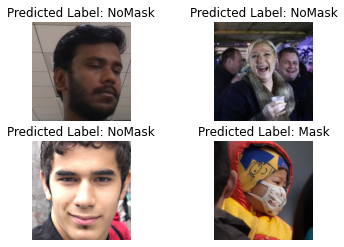

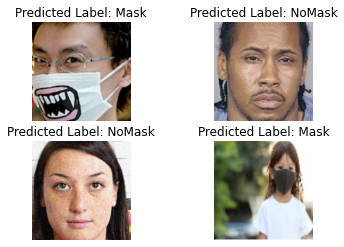

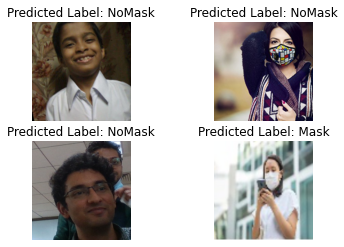

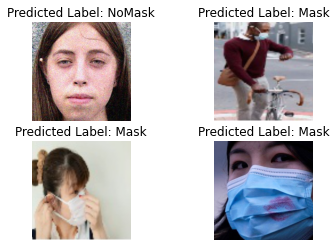

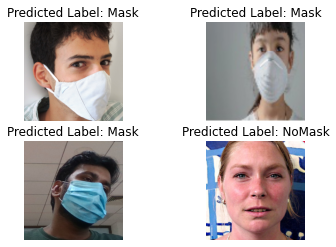

In [10]:
#Visualize some predictions 
import matplotlib.pyplot as plt
# fig = plt.figure()
shown_batch = 0
with torch.no_grad():
    for (images, labels) in dataloaders['test']:
        index = 0
        if shown_batch == 5:
            break
        shown_batch += 1
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = model(images)                            #The output is of shape (4,2)
        _, preds = torch.max(outputs, 1)                        #The pred is of shape (4) --> [ 0,  0,  0,  1]
        
        for i in range(4):
            index += 1
#             fig = plt.figure(index)
            ax = plt.subplot(2,2,index)
            ax.axis('off')
            ax.set_title('Predicted Label: {}'.format(class_names[preds[i]]))
            input_img = images.cpu().data[i]                    #Get the tensor of the image, and put it to cpu  
            inp = input_img.numpy().transpose((1, 2, 0))        #If we have a tensor of shape (2,3,4) --> it becomes (3,4,2)
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1)
            plt.imshow(inp)
        plt.show()

In [11]:
# to store
torch.save({
    'state_dict': model.state_dict(),
    'optimizer' : optimizer.state_dict(),
}, 'FaceMaskDetectionModel_jpg.pth.tar')

In [ ]:
################################################################################################
############### Load pretrained Facemaskdetection model   ######################################
################################################################################################

In [15]:
# import Library
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import os
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# transform = transforms.Compose([transforms.Resize((400,400)),
#                                 transforms.ToTensor(),
#                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

In [17]:
# load ResNet18
new_model = models.resnet18(pretrained=True)
for param in new_model.parameters():
    param.requires_grad = False

num_neural_last_layer = new_model.fc.in_features  # No of neural in last layer
# print(num_neural_last_layer)
new_model.fc = nn.Linear(num_neural_last_layer, 2)  # as we have only 2 class

if torch.cuda.is_available():
    new_model = new_model.cuda()
    

In [18]:
# to load
checkpoint = torch.load('FaceMaskDetectionModel2.pth.tar')
new_model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [19]:
new_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloaders['test']:
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        outputs = new_model(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    print('Accuracy on test data is {}%'.format(100*correct//total))

/home/artpark/anaconda3/envs/ew/lib/python3.9/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Accuracy on test data is 91%


(433, 327, 3)
(1, 433, 327, 3)
torch.Size([1, 3, 433, 327])
torch.Size([1, 3, 433, 327])


RuntimeError: Input type (torch.cuda.ByteTensor) and weight type (torch.cuda.FloatTensor) should be the same

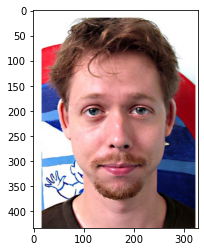

In [20]:
class_names = ['Mask', 'NoMask']
img = plt.imread('325.jpg')
plt.imshow(img)
print(img.shape)
# img = img.resize((400, 400, 3))
img = np.expand_dims(img, axis=0)
print(img.shape)

img = torch.tensor(img)
img = img.numpy().transpose((0, 3, 1, 2)) 
img = torch.tensor(img)
print(img.shape)
img = Variable(img)
print(img.shape)
img = img.cuda()
out = new_model(img)
_, predd = torch.max(out, 1)
# predd = predd.numpy()
print(predd)
# print(class_names[predd[0]])

In [ ]:
import cv2

In [ ]:
# img = plt.imread('image_21.png')
cap = cv2.VideoCapture(1)




while True:
    ret, img = cap.read()
    if ret:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        print(img.shape)
        # img = img.resize((400, 400, 3))
        img = np.expand_dims(img, axis=0)
        print(img.shape)

        img = torch.tensor(img)
        img = img.numpy().transpose((0, 3, 1, 2)) 
        img = torch.tensor(img)
        print(img.shape)
        img = Variable(img)
        print(img.shape)
        # img = img.cuda()
        out = new_model(img)
        _, predd = torch.max(out, 1)
        predd = predd.numpy()
        print(predd)
        cv2.imshow('final', img)
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break

In [ ]:
# img = plt.imread('image_21.png')
cap = cv2.VideoCapture(1)




while True:
    ret, img = cap.read()
    if ret:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        print(img.shape)
        # img = img.resize((400, 400, 3))
        img = np.expand_dims(img, axis=0)
        print(img.shape)

        img = torch.tensor(img)
        img = img.numpy().transpose((0, 3, 1, 2)) 
        img = torch.tensor(img)
        print(img.shape)
        img = Variable(img)
        print(img.shape)
        # img = img.cuda()
        out = new_model(img)
        _, predd = torch.max(out, 1)
        predd = predd.numpy()
        print(predd)
        cv2.imshow('final', img)
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        breaks